Analizamos si hay valores faltantes, nulos y el tipo de las columnas

In [ ]:
import pandas as pd

# Definir el tamaño del bloque
block_size = 10000

# Crear un generador de bloques de datos
data_iterator = pd.read_json('tip.json', lines=True, chunksize=block_size)


# Inicializar listas para almacenar los resultados
missing_values_list = []
null_values_list = []
data_types_list = []

# Iterar sobre los bloques de datos
for data_block in data_iterator:
    # Verificar si hay valores faltantes
    missing_values = data_block.isnull().sum()
    missing_values_list.append(missing_values)

    # Verificar si hay valores nulos
    null_values = data_block.isna().sum()
    null_values_list.append(null_values)

    # Obtener los tipos de datos de cada columna
    data_types = data_block.dtypes
    data_types_list.append(data_types)

# Concatenar los resultados en un solo DataFrame
missing_values_df = pd.concat(missing_values_list)
null_values_df = pd.concat(null_values_list)
data_types_df = pd.concat(data_types_list)

# Calcular el total de valores faltantes y nulos por columna
missing_values_total = missing_values_df.groupby(missing_values_df.index).sum()
null_values_total = null_values_df.groupby(null_values_df.index).sum()

# Imprimir los resultados
print("Valores faltantes por columna:")
print(missing_values_total)
print("\nValores nulos por columna:")
print(null_values_total)
print("\nTipos de datos por columna:")
print(data_types_df)


Como podemos ver no hay valores faltantes ni nulos y podemos ver el tipo de datos y vemos que estan en el tipo correcto. Por otro lado no sacaremos columnas ya que todas nos pueden ser de utilidad. 

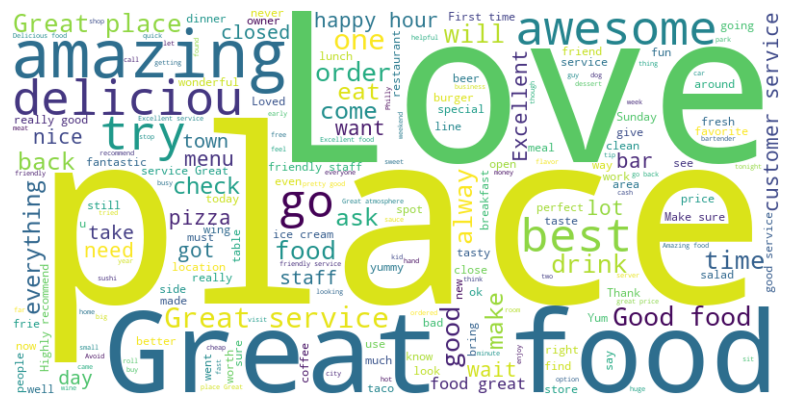

In [32]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Definir el tamaño del bloque
chunksize = 1000

# Inicializar la lista para almacenar los textos
texts = []

# Leer el archivo JSON en bloques
for chunk in pd.read_json('tip.json', lines=True, chunksize=chunksize):
    # Filtrar la columna "text" y convertir a cadena de texto
    text = ' '.join(chunk['text'].astype(str).values)
    texts.append(text)

# Concatenar todos los textos en una sola cadena
text = ' '.join(texts)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Hicimos una nuve de palabras y no pudimos inferir nada ya que es muy general, intentaremos filtrarlo por la palabra "beer" a ver que podemos inferir.

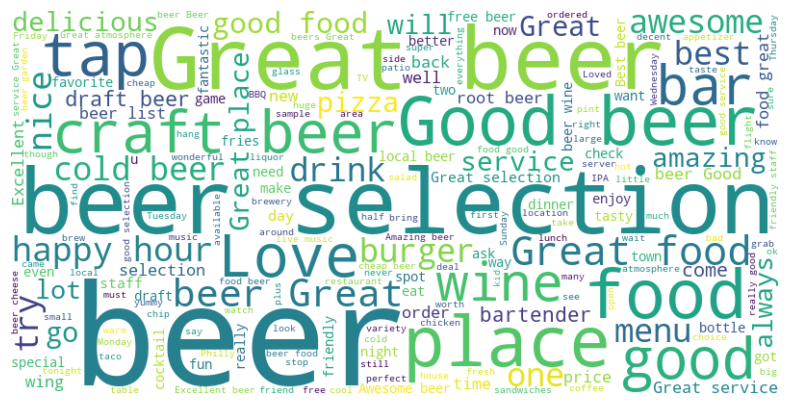

In [34]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Definir el tamaño del bloque
chunksize = 1000

# Inicializar una lista para almacenar los bloques de datos
data_blocks = []

# Leer el archivo JSON en bloques
for chunk in pd.read_json('tip.json', lines=True, chunksize=chunksize):
    data_blocks.append(chunk)

# Concatenar todos los bloques en un único DataFrame
df = pd.concat(data_blocks)

# Filtrar las frases que contienen la palabra "beer"
df_filtered = df[df['text'].str.contains('beer', case=False)]

# Concatenar todas las frases filtradas en una sola cadena
text = ' '.join(df_filtered['text'].astype(str).values)

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Hicimos una nuve de palabras que contenga la palabra beer para ver palabras o fraces relevantes cuando estamos hablando de cervezas, por ejemplo Happy hour, food grear (que vemos que aparece mucho menos que otras palabras, lo que nos puede dar ideas de por donde avanzar para determinar el porque un bar es exitoso y porque no). Ahora es cuestion de unir el datasets de business_id filtrado por cervecerias y aplicar la nuve de palabras para ver que nuevas inferencias podemos hacer con el dataset filtrado

#### Hacemos un analisis de sentimiento de la columna "text"

In [37]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

# Definir el tamaño del bloque
chunksize = 1000

# Inicializar una lista para almacenar los bloques de datos
data_blocks = []

# Leer el archivo JSON en bloques
for chunk in pd.read_json('tip.json', lines=True, chunksize=chunksize):
    data_blocks.append(chunk)

# Concatenar todos los bloques en un único DataFrame
df = pd.concat(data_blocks)

# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Función para aplicar el análisis de sentimientos en un bloque de datos


def analyze_sentiment(chunk):
    chunk['sentiment_score'] = chunk['text'].apply(
        lambda x: sia.polarity_scores(x)['compound'])
    return chunk


# Aplicar el análisis de sentimientos en cada bloque de datos
df = pd.concat([analyze_sentiment(chunk) for chunk in data_blocks])

# Mostrar el DataFrame con los resultados del análisis de sentimientos
print(df[['text', 'sentiment_score']])


                                                     text  sentiment_score
0                          Avengers time with the ladies.           0.0000
1       They have lots of good deserts and tasty cuban...           0.4404
2                  It's open even when you think it isn't           0.0000
3                               Very decent fried chicken           0.0000
4                  Appetizers.. platter special for lunch           0.4019
...                                                   ...              ...
908910              Disappointed in one of your managers.          -0.4767
908911                            Great food and service.           0.6249
908912                                Love their Cubans!!           0.6988
908913                            Great pizza great price           0.8481
908914                  Food is good value but a bit hot!           0.4482

[908915 rows x 2 columns]


Ahora aplicamos un modelo de machine learning pre entrenado para hacer un analisis de sentimientos de todos los tips, vemos que funciona y da resultados bastante certeros como Disappointed in one of your managers.-0.4767 o Love their Cubans! 0.6988. Esto nos puede dar informacion extra cuando filtremos solo las cervecerias, la idea es segmentar por comentarios positivos y negativos y sacar inferencias a partir de ahi.

Revisamos el rango de la columna compliment_count a ver que nos puede decir

In [26]:
import pandas as pd

# Definir el tamaño de bloque
block_size = 1000

# Inicializar variables para almacenar el valor mínimo y máximo
min_value = float('inf')
max_value = float('-inf')

# Crear un generador de bloques de datos
data_iterator = pd.read_json('tip.json', lines=True, chunksize=block_size)

# Iterar sobre los bloques de datos
for data_block in data_iterator:
    # Obtener el valor mínimo y máximo en el bloque actual
    block_min = data_block['compliment_count'].min()
    block_max = data_block['compliment_count'].max()

    # Actualizar el valor mínimo y máximo globales
    min_value = min(min_value, block_min)
    max_value = max(max_value, block_max)

print("Valor mínimo de compliment_count:", min_value)
print("Valor máximo de compliment_count:", max_value)


Valor mínimo de compliment_count: 0
Valor máximo de compliment_count: 6


El valor maximo de compliment_count es muy bajo como para considerarlo como dato de valor por lo que no lo usaremos para nuestro analisis.